# Theory and Toy Problems

In [1]:
import graph_structure as gs
import numpy as np
from tqdm import tqdm
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import scipy.stats as st

# Adding white noise

In [2]:
n_samples = 100
dim = 50
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
ks = list(range(1, n_samples))

In [3]:
def alpha_from_snr(snr):
    return 10**(-snr / 20)

def make_curves(seed, n_samples, dim, snrs, ks):    
    np.random.seed(seed)
    x = np.random.randn(n_samples, dim)
    nx = gs.nearest_neighbors(x)
    curves = []
    for snr in snrs:
        alpha = alpha_from_snr(snr)
        y = x + alpha * (np.random.randn(n_samples, dim))
        ny = gs.nearest_neighbors(y)
        res = []
        for k in ks:
            if k == 0:
                res.append(0)
                continue
            res.append(gs.mean_neighborhood_similarity_from_neighborhood(nx, ny, k))
        curves.append(res)

    return np.array(curves)

In [5]:
n_samples = 100
dim = 50
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
ks = list(range(1, n_samples))
all_curves = Parallel(n_jobs=-1, verbose=10)(delayed(make_curves)(n, n_samples, dim, snrs, ks)
                                             for n in range(48))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of  48 | elapsed:    4.1s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   8 out of  48 | elapsed:    4.2s remaining:   21.1s
[Parallel(n_jobs=-1)]: Done  13 out of  48 | elapsed:    4.3s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  18 out of  48 | elapsed:    4.3s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  23 out of  48 | elapsed:    4.4s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  28 out of  48 | elapsed:    4.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  33 out of  48 | elapsed:    4.5s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:    4.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:    4.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    4.6s finished


In [6]:
# Hypergeometric
# M = number of possibilities
# N = number of possibilities of victory
# n = number of trials
M = n_samples-1
n = ks[:-2]
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

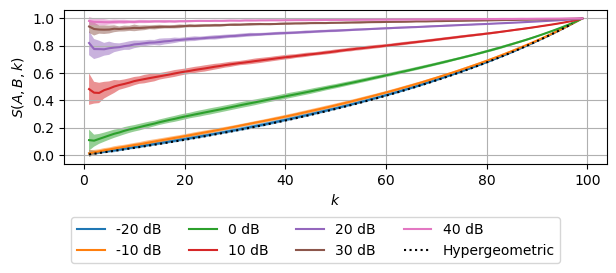

In [7]:

all_curves_ = np.array(all_curves)
curves = np.mean(all_curves_, axis=0)
errors = np.std(all_curves_, axis=0)*2

curves.shape
labels = [f'{s} dB' for s in snrs]

plt.figure(figsize=(7, 2))

for c in range(curves.shape[0]):
    plt.plot(ks, curves[c,:], label=labels[c])
    plt.fill_between(ks, curves[c,:]+errors[c,:], curves[c,:]-errors[c,:], alpha=0.5)

plt.plot(n, js, 'k:', label='Hypergeometric')

plt.xlabel('$k$')
plt.ylabel('$S(A,B,k)$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
#plt.semilogx()
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.savefig('sabk_white_noise_100.pdf', bbox_inches='tight')
plt.show()

# 

# Impact of noise level

In [40]:
n_samples = 100
dim = 50
k = 20
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
snrs = np.linspace(-20, 60, 25)
alphas = np.sqrt(10**(-snrs / 10))
res = []
stds = []
n_repetitions = 10

for alpha in tqdm(alphas):
    this_res = []    
    for _ in range(n_repetitions):
        A = np.random.randn(n_samples, dim)
        B = A + alpha * np.random.randn(n_samples, dim)
        s = gs.mean_neighborhood_similarity_from_points(A, B, k)
        this_res.append(s)
    res.append(np.mean(this_res))
    stds.append(np.std(this_res))

100%|██████████| 25/25 [00:01<00:00, 24.67it/s]


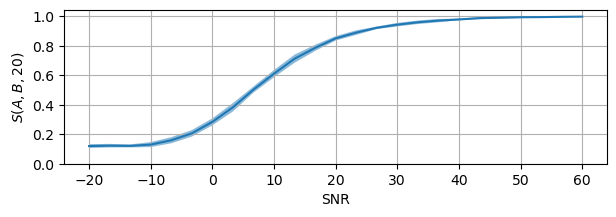

In [41]:
plt.figure(figsize=(7, 2))
snrs = np.array(snrs)
res = np.array(res)
stds = np.array(stds)

plt.plot(snrs, res)
plt.fill_between(snrs, res+np.array(stds)*2, res-np.array(stds)*2, alpha=0.5)
plt.xlabel('SNR')
plt.ylabel(f'$S(A,B,{k})$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
plt.xticks(range(-20, 61, 10))
plt.grid()
plt.savefig('sabk_by_snr.pdf', bbox_inches='tight')
plt.show()

# Impact of dimensions

In [32]:
# argmin_k S(k) and min S(k) do not correlate with dimension (only in <10 dimensions)
snrs = [-20, -10, 0, 10, 20, 30, 40]

dims = list(range(2, 100, 1))
n_samples = 100
k = 20
res = {}
stds = {}
n_repeats = 10
for snr in snrs:
    res[snr] = []
    stds[snr] = []
    for dim in tqdm(dims):
        argm = []
        m = []
        for n in range(n_repeats):
            x = np.random.randn(n_samples, dim)
            A = np.random.randn(n_samples, dim)
            alpha = alpha_from_snr(snr)
            B = A + alpha * np.random.randn(n_samples, dim)
            s = gs.mean_neighborhood_similarity_from_points(A, B, k)
            m.append(s)
        res[snr].append(np.mean(m))
        stds[snr].append(np.std(m))


100%|██████████| 98/98 [00:02<00:00, 33.42it/s]


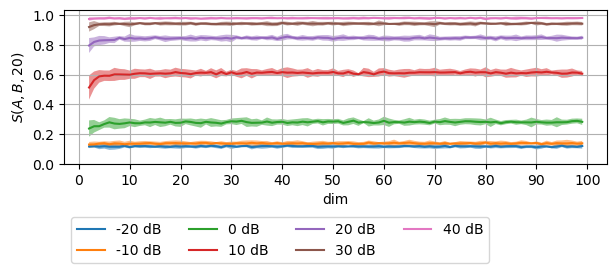

In [36]:
plt.figure(figsize=(7, 2))
for snr in snrs:
    plt.plot(dims, res[snr], label=f'{snr} dB')
    plt.fill_between(dims, res[snr]+np.array(stds[snr])*2, res[snr]-np.array(stds[snr])*2, alpha=0.5)
plt.xlabel('dim')
plt.ylabel(f'$S(A, B, {k})$')
plt.xticks(range(0, 110, 10))
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.savefig('sabk_dimensions.pdf', bbox_inches='tight')
plt.show()

# Changing the location of clusters

In [134]:
c = 5
n_clusters = 5
dim = 50
samples_per_cluster = 20
np.random.seed(65)
clusters = np.random.randn(n_clusters, dim) * c

n_samples = samples_per_cluster * clusters.shape[0]


In [135]:
def make_curves_clusters(seed, samples_per_cluster, clusters, dim, snrs, ks):    
    n_samples = samples_per_cluster * clusters.shape[0]
    np.random.seed(seed)
    x = np.vstack([np.random.randn(samples_per_cluster, dim) + clusters[i,:] for i in range(clusters.shape[0])])
    y = np.vstack([ np.random.randn(samples_per_cluster, dim) + clusters[(i+1) % 3]  for i in range(clusters.shape[0])])
    nx = gs.nearest_neighbors(x)
    curves = []
    for snr in snrs:
        alpha = alpha_from_snr(snr)
        y = x + alpha * (np.random.randn(n_samples, dim))
        ny = gs.nearest_neighbors(y)
        res = []
        for k in ks:
            if k == 0:
                res.append(0)
                continue
            res.append(gs.mean_neighborhood_similarity_from_neighborhood(nx, ny, k))
        curves.append(res)

    return np.array(curves)

In [136]:
n_samples = 100
dim = 50
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
ks = list(range(1, samples_per_cluster*clusters.shape[0]-1))
all_curves = Parallel(n_jobs=-1, verbose=10)(delayed(make_curves_clusters)(n, samples_per_cluster, clusters, dim, snrs, ks)
                                             for n in range(48))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  48 | elapsed:    2.0s remaining:   29.5s
[Parallel(n_jobs=-1)]: Done   8 out of  48 | elapsed:    2.0s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  13 out of  48 | elapsed:    2.0s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  18 out of  48 | elapsed:    2.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  23 out of  48 | elapsed:    2.0s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  28 out of  48 | elapsed:    2.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  33 out of  48 | elapsed:    2.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    2.4s finished


In [137]:
# Hypergeometric
# M = number of possibilities
# N = number of possibilities of victory
# n = number of trials
M = n_samples-1
n = ks[:-2]
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

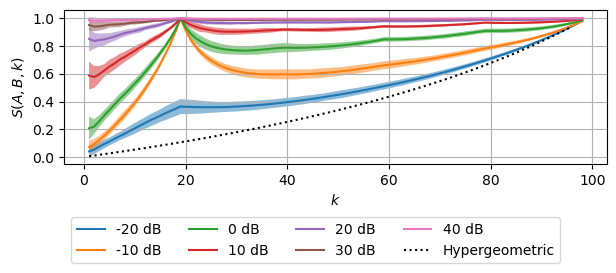

In [139]:
all_curves_ = np.array(all_curves)
curves = np.mean(all_curves_, axis=0)
errors = np.std(all_curves_, axis=0)*2

curves.shape
labels = [f'{s} dB' for s in snrs]

plt.figure(figsize=(7, 2))

for c in range(curves.shape[0]):
    plt.plot(ks, curves[c,:], label=labels[c])
    plt.fill_between(ks, curves[c,:]+errors[c,:], curves[c,:]-errors[c,:], alpha=0.5)

plt.plot(n, js, 'k:', label='Hypergeometric')

plt.xlabel('$k$')
plt.ylabel('$S(A,B,k)$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
#plt.semilogx()
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.savefig('clustered_with_whitenoise.pdf', bbox_inches='tight')
plt.show()